# <center> Modélisation

In [2]:
%run "./Ouverture_donnees.ipynb"

Les importations nécessaires à la modélisation : 

In [3]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import tree

In [4]:
#df_accidents.columns

Dans cette section, nous cherchons à prédire la gravité de l'accident grâce aux variables explicatives telles que le type de la collision, le type de la route, la luminosité, etc. \
Pour cela, notre variable cible s'appelle "gravite", elle vaut 1 si lors de l'accident, il y a eu au moins un blessé hospitalisé et/ou une personne tuée et elle vaut 0 sinon (les usagers sont soit indemnes, soit des blessés légers).

## Préparation des données

Pour une meilleure modélisation, il est essentiel d'avoir un nombre de modalités raisonnable. Ainsi, nous regroupons les modalités ensemble si elles correspondent à un pourcentage d'accidents graves proche.

In [5]:
# Mettre des modalités ensemble :
df_accidents["collision"] = df_accidents["collision"].replace(["2 - frontale", "2-arriere", "3 vehicules", "2-cote"], "2 ou 3 véhicules")

df_accidents["catr"] = df_accidents["catr"].replace(["Route départementale", "Route nationale", "Autre"], "Route départementale ou nationale + Autre")
df_accidents["catr"] = df_accidents["catr"].replace(["Autoroute", "Voie Communale"], "Autoroute + Voie Communale")

df_accidents["lum"] = df_accidents["lum"].replace(["Crépuscule ou aube"], "Plein jour")

## Sélection de variables
Dans un premier temps, on étudie le pouvoir prédictif des variables explicatives. \
Le V de Cramer mesure l'association entre la variable explicative et la variable cible "gravité". On a réalisé un test d'indépendance du Chi-2. Si la p-valeur est inférieur à 0.05, alors l'hypothèse nulle d'indépendance est rejetée et il existe une dépendance entre la variable explicative et la variable cible. \
On retrouve ci-dessous les différentes valeurs de V de Cramer et de p-valeurs.

In [6]:
colonne = ["agglo", "lum", "int", "collision", "atm", "catr", "circ", "surf", "prof", "plan", "infra", "situ"]

def cramers(df):
    L_cramer = []
    L_pvalue = []
    L_var = []
    for elem in colonne :
        crosstab = pd.crosstab(df[elem], df.gravite, margins = True, normalize = 'index')*100
        chi2 = ss.chi2_contingency(crosstab)[0]
        p_value = round(ss.chi2_contingency(crosstab)[1], 3)
        n = sum(crosstab.sum())
        VCramer = round(np.sqrt(chi2 / (n*(min(crosstab.shape)-1))), 3)
        #print("Pour la variable " + elem + ", le V de Cramer est : " + VCramer.astype(str))
        #print("La p-valeur du test du Chi-2 est : " + p_value.astype(str))
        L_cramer.append(VCramer)
        L_pvalue.append(p_value)
        L_var.append(elem)
    tableau = np.array([L_cramer, L_pvalue])
    pd_tableau = pd.DataFrame(tableau.T, index = L_var, columns = ['V de Cramer', 'p_value'])
    return pd_tableau.sort_values("p_value")

cramers(df_accidents)

,V de Cramer,p_value
catr,0.225,0.000
situ,0.298,0.000
agglo,0.214,0.001
circ,0.203,0.001
lum,0.196,0.002
plan,0.158,0.023
collision,0.149,0.031
prof,0.097,0.245
atm,0.082,0.444
int,0.081,0.453


Ainsi, les variables utilisées seront Catr (le type de route), Situ (lieu de l'accident), Agglo (si l'accident a lieu en agglomération), Circ (le sens de circulation), Lum (la lminosité), plan (si la route est rectiligne ou courbée) et collision.

Créer les indicatrices nécessaires

In [7]:
# Variable cible :
df_accidents["y"] = (df_accidents["gravite"]==2).astype(int)


# Variables explicatives :
df_accidents["Sans collision"] = pd.get_dummies(df_accidents["collision"])["Sans collision"]
df_accidents["Autre collision"] = pd.get_dummies(df_accidents["collision"])["autre"]

df_accidents["Route dep ou nationale"] = pd.get_dummies(df_accidents["catr"])["Route départementale ou nationale + Autre"]

df_accidents["Sur accotement"] = pd.get_dummies(df_accidents["situ"])["Sur accotement"]
df_accidents["Autre lieu de l'accident"] = pd.get_dummies(df_accidents["situ"])["Autre"]

df_accidents["Hors agglomeration"] = pd.get_dummies(df_accidents["agglo"])["Hors agglomeration"]

df_accidents["A chaussées séparées"] = pd.get_dummies(df_accidents["circ"])["A chaussées séparées"]
df_accidents["Bidirectionnelle"] = pd.get_dummies(df_accidents["circ"])["Bidirectionnelle"]

df_accidents["Nuit sans éclairage"] = pd.get_dummies(df_accidents["lum"])["Nuit sans éclairage public"]
df_accidents["Plein jour"] = pd.get_dummies(df_accidents["lum"])["Plein jour"]

df_accidents["Courbe"] = pd.get_dummies(df_accidents["plan"])["Courbe"]

In [128]:
#data = pd.get_dummies(df_accidents[col],drop_first=True)

Créer les échantillons de test et d'apprentissage

In [8]:
# Les variables explicatives sous forme d'indicatrices
col = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "A chaussées séparées", "Bidirectionnelle", "Nuit sans éclairage", "Plein jour",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp = df_accidents[col]

# Création des échantillons de test et d'apprentissage
xTrain, xTest, yTrain, yTest = train_test_split(df_temp, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

## Modélisation et performance du modèle

Nous allons étudier différents types de modèles :
* Classification
* Régression linéaire
* Arbre de décision

Pour cela, nous codons des fonctions pour tracer les courbes ROC et les matrices de confusion.

### Fonctions utiles

In [9]:
def courbe_roc(modele) :
    prob_sans_modele = [0 for _ in range(len(yTest))]
    # predict probabilities
    prob_pred = modele.predict_proba(xTest)
    # keep probabilities for the positive outcome only
    prob_pred = prob_pred[:, 1]
    # calculate scores
    auc_sans_modele = roc_auc_score(yTest, prob_sans_modele)
    auc = roc_auc_score(yTest, prob_pred)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle logistique : ROC AUC=%.3f' % (auc))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(yTest, prob_sans_modele)
    fpr, tpr, _ = roc_curve(yTest, prob_pred)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr, tpr, label='Modèle logistique')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show() 

In [10]:
def matrice_confusion(modele) :
    sklearn.metrics.plot_confusion_matrix(modele, xTest, yTest)
    plt.show()

### Classification
On réalise une classification comme dans le TP vu en cours (expliquer le principe ?)

In [74]:
classification = svm.SVC(kernel='linear', C=1, probability = True).fit(xTrain, yTrain)
y_pred = clf.predict(xTest)

In [57]:
# Les indicateurs (cf le TP sur la classification)
sc_accuracy = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_f1 = sklearn.metrics.f1_score(y_pred, yTest)
sc_recall = sklearn.metrics.recall_score(y_pred, yTest)
sc_precision = sklearn.metrics.precision_score(y_pred, yTest)

In [58]:
print(sc_accuracy)
print(sc_f1)
print(sc_recall)
print(sc_precision)

0.7203433038749151
0.5213090909090909
0.6624768946395564
0.42973621103117504


Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.713


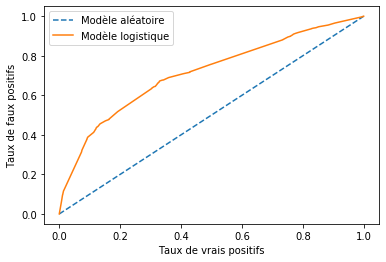

In [86]:
courbe_roc(classification)

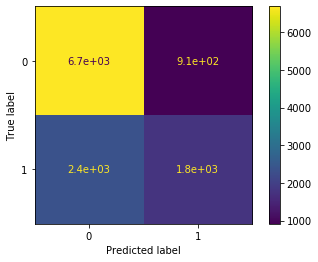

In [81]:
matrice_confusion(classification)

### Régression logistique

In [11]:
import statsmodels as sm
from statsmodels.tools import add_constant
XTrainBis = sm.tools.add_constant(xTrain)
print(XTrainBis.info())

from statsmodels.api import Logit
#régression logistique - on passe la cible et les explicatives
modele_logistique = Logit(endog=yTrain,exog=XTrainBis).fit()

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 47072 entries, 126521 to 6056
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   const                     47072 non-null  float64
 1   Route dep ou nationale    47072 non-null  uint8  
 2   Sur accotement            47072 non-null  uint8  
 3   Autre lieu de l'accident  47072 non-null  uint8  
 4   Hors agglomeration        47072 non-null  uint8  
 5   A chaussées séparées      47072 non-null  uint8  
 6   Bidirectionnelle          47072 non-null  uint8  
 7   Nuit sans éclairage       47072 non-null  uint8  
 8   Plein jour                47072 non-null  uint8  
 9   Sans collision            47072 non-null  uint8  
 10  Autre collision           47072 non-null  uint8  
 11  Courbe                    47072 non-null  uint8  
dtypes: float64(1), uint8(11)
memory usage: 1.2 MB
None
Optimization terminated successfully.
         Current functi

In [14]:
print(modele_logistique.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                47072
Model:                          Logit   Df Residuals:                    47060
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  0.1362
Time:                        13:52:07   Log-Likelihood:                -26619.
converged:                       True   LL-Null:                       -30818.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2406      0.038    -59.425      0.000      -2.315      -2.167
Route dep ou nationale       0.7660      0.022     34.347      0.000       0.722       0.

On remarque que les variables "A chaussées séparées" et "Plein jour" ne sont pas significatives au seuil de 5%.

### Arbre de décision